In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from signal_pytorch import csd
import torch

# Find peak frequencies for all subjects and regions, comparing LSD and placebo experiments 

In [3]:
def find_peak_freq(sub, roi, exp):
    file_name = f"../time_series/sub-{str(sub).zfill(3)}-{exp}-ROI{roi}.txt"
    observed_bold = np.loadtxt(file_name, delimiter=',')
    observed_bold = observed_bold / observed_bold.std()
    f, csdx = csd(observed_bold, observed_bold, fs=0.5, nperseg=100)
    f = torch.fft.fftshift(f)
    csdx = torch.fft.fftshift(csdx)
    peak_index = np.argmax(csdx[50:])
    peak_frequency = f[50:][peak_index]
    return peak_frequency
    
    

In [ ]:
# go through every spectrum - get peak frequency & save in a txt file in order
subs = [1, 2, 3, 4, 6, 10, 11, 12, 19, 20]
def find_peak_frequencies(csds, frequencies):
    peak_frequencies = []
    for csd in csds:
        
        peak_index = np.argmax(csd[50:])
        peak_frequency = frequencies[50:][peak_index]
        peak_frequencies.append(peak_frequency)
        
    print(np.array(peak_frequencies))
    return np.array(peak_frequencies)

csds = []
for sub in subs:
    print(sub)
    for roi in range(100):
        file_name = f"../time_series/sub-{str(sub).zfill(3)}-LSD-ROI{roi}.txt"
        observed_bold = np.loadtxt(file_name, delimiter=',')
        observed_bold = observed_bold / observed_bold.std()
        f, csdx = csd(observed_bold, observed_bold, fs=0.5, nperseg=100)
        csds.append(torch.fft.fftshift(csdx))

peak_frequencies_lsd = find_peak_frequencies(csds, torch.fft.fftshift(f))
print(len(csds), peak_frequencies_lsd.shape)
np.savetxt('peak_frequencies.txt', peak_frequencies_lsd, delimiter=',') 
print(torch.fft.fftshift(f)[50:])

In [ ]:

csds = []
for sub in subs:
    print(sub)
    for roi in range(100):
        file_name = f"../time_series/sub-{str(sub).zfill(3)}-PLCB-ROI{roi}.txt"
        observed_bold = np.loadtxt(file_name, delimiter=',')
        observed_bold = observed_bold / observed_bold.std()
        f, csdx = csd(observed_bold, observed_bold, fs=0.5, nperseg=100)
        csds.append(torch.fft.fftshift(csdx))

peak_frequencies_plcb = find_peak_frequencies(csds, torch.fft.fftshift(f))
np.savetxt('peak_frequencies.txt', peak_frequencies_plcb, delimiter=',') 
print(torch.fft.fftshift(f)[50:])

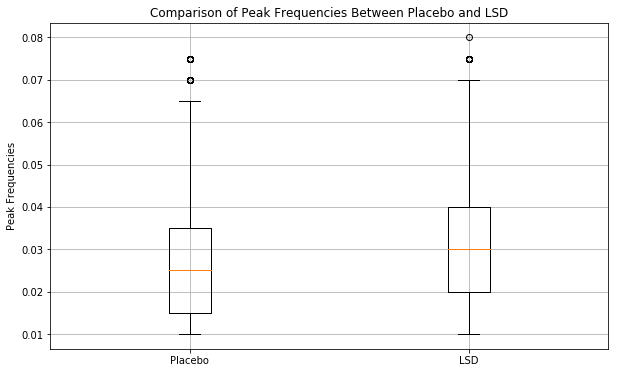

In [11]:
# plot box plot

# Creating the box plot
data = [peak_frequencies_plcb, peak_frequencies_lsd]
labels = ['Placebo', 'LSD']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.ylabel('Peak Frequencies')
plt.title('Comparison of Peak Frequencies Between Placebo and LSD')
plt.grid(True)
plt.show()

# Find lowest loss achieved by our method for every subject and regions for both experiments

Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is complex, switching to return_onesided=False
Input data is 

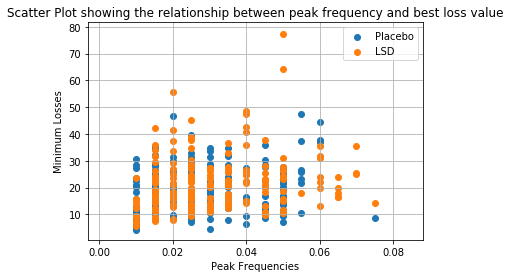

In [4]:
# go through every loss file and get lowest loss - save in a txt file in order
subs = [1, 2, 3, 4]
min_losses_plcb = []
peak_freqs_plcb = []
for sub in subs:
    for roi in range(100):

        file_name = f"losses-sub-{str(sub).zfill(3)}-PLCB-ROI{roi}.json"
        try:
            with open(file_name, 'r') as f:
                losses = json.load(f)
        except:
            pass
        else:
            min_losses_plcb.append(np.min(losses))
            p = find_peak_freq(sub, roi, "PLCB")
            peak_freqs_plcb.append(p.detach())

plt.scatter(np.array(peak_freqs_plcb), np.array(min_losses_plcb), label='Placebo')
min_losses_lsd = []
peak_freqs_lsd = []
for sub in subs:
    for roi in range(100):

        file_name = f"losses-sub-{str(sub).zfill(3)}-LSD-ROI{roi}.json"
        try:
            with open(file_name, 'r') as f:
                losses = json.load(f)
            min_losses_lsd.append(np.min(losses))
            peak_freqs_lsd.append(find_peak_freq(sub, roi, "LSD").detach())
        except:
            pass

plt.scatter(np.array(peak_freqs_lsd), np.array(min_losses_lsd), label='LSD')
plt.xlabel('Peak Frequencies')
plt.ylabel('Minimum Losses')
plt.title('Scatter Plot showing the relationship between peak frequency and best loss value')
plt.legend()
plt.grid(True)
plt.show()

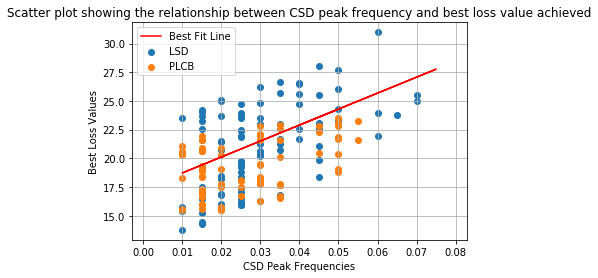

In [19]:
from scipy.stats import zscore
peak_freqs_lsd = np.array(peak_freqs_lsd)
peak_freqs_plcb = np.array(peak_freqs_plcb)
min_losses_lsd = np.array(min_losses_lsd)
min_losses_plcb = np.array(min_losses_plcb)

# Calculate the line of best fit
coefficients = np.polyfit(peak_freqs_lsd, min_losses_lsd, 1)
poly = np.poly1d(coefficients)
line_of_best_fit = poly(peak_freqs_lsd)

coefficients = np.polyfit(peak_freqs_plcb, min_losses_plcb, 1)
poly = np.poly1d(coefficients)
lobf = poly(peak_freqs_plcb)


residuals = np.abs(min_losses_lsd - line_of_best_fit)
threshold =  0.8 * np.std(residuals)
non_outlier_mask = residuals <= threshold
fp_lsd = peak_freqs_lsd[non_outlier_mask]
f_losses_lsd = min_losses_lsd[non_outlier_mask]

residuals = np.abs(min_losses_plcb - lobf)
threshold =  0.8 * np.std(residuals)
non_outlier_mask = residuals <= threshold
fp_plcb = peak_freqs_plcb[non_outlier_mask]
f_losses_plcb = min_losses_plcb[non_outlier_mask]


plt.scatter(fp_lsd, f_losses_lsd, label='LSD')
plt.scatter(fp_plcb, f_losses_plcb, label='PLCB')
plt.xlabel('CSD Peak Frequencies')
plt.ylabel('Best Loss Values')
plt.title('Scatter plot showing the relationship between CSD peak frequency and best loss value achieved')
plt.legend()
plt.grid(True)
# Plot the line of best fit
plt.plot(peak_freqs_lsd, line_of_best_fit, color='red', label='Best Fit Line')
plt.legend()

# Show the plot
plt.show()

# T-test to determine whether the mean peak frequencies differ between the spectra from the placebo and LSD experiment

In [14]:
import scipy.stats as stats

# Sample data
lsd_data = peak_frequencies_lsd
placebo_data = peak_frequencies_plcb

# Perform t-test
t_stat, p_value = stats.ttest_ind(lsd_data, placebo_data, equal_var=True)  # Use equal_var=False for Welch's t-test

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.1
if p_value < alpha:
    print("Reject the null hypothesis: There is enough evidence to suggest that the mean frequencies are different.")
else:
    print("Fail to reject the null hypothesis: There is not enough evidence to suggest that the mean frequencies are different.")


T-statistic: 5.157728205095364
P-value: 2.7467935190012857e-07
Reject the null hypothesis: There is enough evidence to suggest that the mean frequencies are different.
